In [1]:
import numpy as np
from graph_cert.certify import *
from graph_cert.utils import *

import seaborn as sns
import matplotlib.pyplot as plt

### Load and preprocess the data
- Make the graph undirected
- Selected the nodes belonging to the largest connected component

In [2]:
file_name = 'data/cora.npz'
graph = load_dataset(file_name=file_name)
adj = graph['adj_matrix']
labels = graph['labels'] 
adj, labels = standardize(adj_matrix=adj, labels=labels)

### Load a pretrained $\pi$-PPNP model

In [3]:
loaded = np.load('data/cora_pretrained_logits.npz')

# pretrained logits (before diffusion)
logits = loaded['logits']

# indices of the nodes in the train/val/test split
split_train = loaded['split_train']
split_val = loaded['split_val']
split_test = loaded['split_test']

### Evaluate the performance on the clean graph

In [4]:
alpha = 0.85

# PageRank Matrix of the clean graph
ppr_clean = propagation_matrix(adj=adj, alpha=alpha)

weighted_logits = ppr_clean @ logits
predicted = weighted_logits.argmax(1)

print('Clean Accuracy: {:.2f}'.format((labels[split_test] == predicted[split_test]).mean()))

Clean Accuracy: 0.84


### Generate the set of fragile edges

In [5]:
fragile = get_fragile(adj=adj, threat_model='rem')

### Compute the (local budget) certificate for a single target node

In [6]:
# set the local budget proportional to the degree
deg = adj.sum(1).A1.astype(np.int32)
local_budget = np.maximum(deg - 5, 0)

target = split_test[0]
true_class = predicted[target]
# set the true_class to the predicted class for the target node

worst_margin, opt_fragile= certify_single_node_local(
    adj=adj, alpha=alpha, fragile=fragile, local_budget=local_budget, logits=logits,
    true_class=true_class, target=target)

print('Worst-case Margin for target node {}: {:.2f}, Certified: {}'.format(target, worst_margin, worst_margin>0))

Worst-case Margin for target node 0: 1.57, Certified: True


### Compute the (local budget) certificate for all (test) nodes
Computes the worst margin and the optimal edges to perturb for all K x K pairs of classes, since we can recover the exact worst-case margins for all node via the PageRank matrix of the perturbed graphs. See section 4.3. in the paper for more details.

Note that his is more efficient than calling `certify_single_node_local` n-many times and should be preferred.

In [7]:
# precomputed the K x K perturbed graphs
k_squared_pageranks = k_squared_parallel(
    adj=adj, alpha=alpha, fragile=fragile, local_budget=local_budget, logits=logits)

# compute the exact worst-case margins for all test nodes
worst_margins = worst_margins_given_k_squared(
    k_squared_pageranks=k_squared_pageranks, labels=predicted, logits=logits)

print('Ratio of certified test nodes: {:.2f}'.format((worst_margins[split_test]>0).mean()))

Ratio of certified test nodes: 0.63


### Plot the % certified robust test nodes as we increase the local attack stregth 

`local strength` $s$ corresponds to `local_budget` $b_i=\max(d_i - 11 + s, 0)$ where $d_i$ is the degree of node $i$

In [8]:
local_strengths = [1, 3, 5, 7, 9]
ratios_certifed = []

for local_strength in local_strengths:
    # set the local budget proportional to the node degree
    local_budget = np.maximum(deg - 11 + local_strength, 0)
    
    # precomputed the K x K perturbed graphs
    k_squared_pageranks = k_squared_parallel(
    adj=adj, alpha=alpha, fragile=fragile, local_budget=local_budget, logits=logits)
    
    # compute the exact worst-case margins for all test nodes
    worst_margins = worst_margins_given_k_squared(
        k_squared_pageranks=k_squared_pageranks, labels=predicted, logits=logits)
    
    ratios_certifed.append((worst_margins[split_test]>0).mean())
    print(local_strength, ratios_certifed[-1])

1 0.7861660079051384
3 0.7363636363636363
5 0.6727272727272727
7 0.575098814229249
9 0.47549407114624503


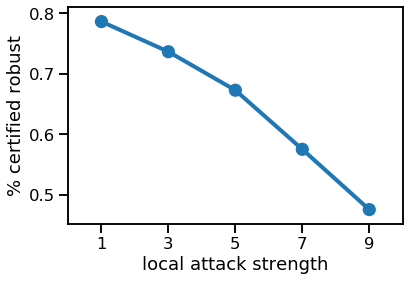

In [9]:
sns.set_context('talk')
sns.pointplot(local_strengths, ratios_certifed)
plt.xlabel('local attack strength')
plt.ylabel('% certified robust')
plt.show()